### Metadata for simulator

In [89]:
import json
import xml.etree.ElementTree as ET
from pathlib import Path

input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata/'
simulation_setup = "lowCongestion_5minDemand"

config = json.load(open(input_path + "/config.json"))
config["NETWORK"] = Path(config["NETWORK"])
config["SUMO"] = Path(config["SUMO"])
# [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
#sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))
sim_setup = json.load(open(input_path + f"simulation_setups_{simulation_setup}.json"))


In [90]:
# excluding warmup period of 15min
# so you need to simulate for at least 15min now. 
warm_up_sec = 15*60 # duration in seconds

# duration, in seconds, of each edge simulation output statistics
# this value should be consistent with what is defined in additional.add.xml
edge_stats_freq = 300

## Main simulator function

In [91]:
import os

def run_sumo(config, sim_setup, prefix_input, prefix_output):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_input}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_{sim_setup['prefix_sim_run']}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)

In [92]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np

def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips

In [93]:
import numpy as np


def compute_nrmse_counts_one_edge(df_true, df_simulated,GT_edge_id):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    # only consider GT_edge_id of interest
    df1 = df1[df1['edge_id']==GT_edge_id]

    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN



In [94]:
import xml.etree.ElementTree as ET
from pathlib import Path

def generate_od_xml(x, config, sim_setup):

    init_od_path = f"{config['NETWORK']}/{sim_setup['init_od']}"

    if Path(init_od_path).is_file():
        print("Reading:",init_od_path)
        tree = ET.parse(init_od_path)
        root = tree.getroot()

        for i,x in enumerate(x):
            root[0][i].attrib["count"] = str(np.round(x,4))
            
    file_name = f"{config['NETWORK']}/{sim_setup['current_od']}"
    print('Saving: '+file_name)
    tree.write(file_name)

## Find upper and lower bounds

In [95]:
import pandas as pd

def transform_od_xml_to_pandas(file_path_xml):

    tree = ET.parse(file_path_xml)
    root = tree.getroot()

    od_mat = []
    for taz_elem in root.iter('tazRelation'):
        od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])
    
    df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

    return df_od

In [96]:
file_path_xml = str(config['NETWORK']) + "/" + sim_setup['gt_od']
df_gt = transform_od_xml_to_pandas(file_path_xml)

In [97]:
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = df_gt.shape[0]

bounds = torch.tensor([
    [ df_gt[ 'tazCount'].min() - 1 for _ in range(dim_od)],
    [ df_gt[ 'tazCount'].max() + 1 for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
         4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
         4., 4., 4., 4., 4., 4.]], dtype=torch.float64)

### Obtain ground-truth value

In [98]:
loop_stats_df_gt, _ = parse_loop_data_xml_to_pandas(
    config,
    loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gt_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"
)


## Vanilla BO with Expected Improvement

In [99]:
### GP model surrogate
from botorch.models.transforms import Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP

from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.constraints import Interval
from botorch import fit_gpytorch_mll


def initialize_gp_model(train_X,train_Y):
    
    dim = train_X.size(dim=1)

    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )

    gp_model = SingleTaskGP(
        train_X, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll

In [100]:

### Acquisition Function: q-EI
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf

sampler = StochasticSampler(sample_shape=torch.Size([128]))
#qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [101]:

def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""

    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)


## Run BayesOpt loop

In [102]:
# Read initial data
df_0 = pd.read_csv(f"./{simulation_setup}_initial_data_bo.csv")

In [103]:
df_0.shape

(50, 43)

In [104]:
df_0.loss.describe()

count    50.000000
mean      0.895565
std       0.035945
min       0.816324
25%       0.866401
50%       0.895104
75%       0.921864
max       0.984166
Name: loss, dtype: float64

In [105]:

### Run loop
NITER = 200
BATCH_SIZE = 5
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

best_value = []


prefix_input = "current"
prefix_output = "current"
loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/{prefix_output}_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

for i in range(NITER):

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    ###
    #Obtain next sampling location given current training data
    ###

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    x_i = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)

    # map the normalized into the original parameter space
    #x_i = unnormalize(x_i, bounds)
    x_i = x_i.cpu().detach().numpy()

    print(f"Next {BATCH_SIZE} sampling locations:{x_i}.")

    # Sample simulator
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        print(f"Generating new OD...")
        generate_od_xml(x_i[j], config, sim_setup)

        # Query simulator
        print(f"Querying simulator...")
        run_sumo(config, sim_setup, prefix_input, prefix_output)

        # Compute metrics
        print(f"Computing metrics...")
        loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

        # Compute loss with respect to gt
        y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = y_i
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])

########### BO iteration=1 ###########
##### best_value=-0.816323829013397 #####
Next 5 sampling locations:[[0.96207024 0.31464409 0.5424494  3.0057475  0.91698197 3.70570944
  2.72303313 0.88584353 3.27830341 3.76630035 3.99216181 2.37833034
  3.41635915 1.55752774 3.14644382 2.85517246 3.08000568 2.55007538
  3.77754825 2.89834964 1.47481936 3.41265117 2.70342311 1.18073294
  2.11606988 3.34064151 1.93839034 3.20443574 2.49053551 1.01817429
  0.07796    3.25103374 2.9918551  2.10498674 0.94364978 0.73373769
  0.88313215 0.09414785 1.87669688 0.51409081 2.9351344  3.19386482]
 [0.71883085 2.90446118 1.64849029 0.20264055 0.43803448 2.24688028
  1.93943551 2.06685486 1.70635826 1.70472658 3.11747389 0.56363567
  3.47831626 2.56734912 0.32824982 1.73947979 2.21635968 2.30382777
  0.29259795 1.81785057 1.7468207  2.39254178 0.98889031 2.25768691
  2.66148506 2.08990236 2.37347197 1.98590474 2.79852389 2.20425582
  2.87475774 1.12403916 0.1833087  2.163741   2.41488981 1.63215334
  3.0729

In [106]:
df_training.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_35,x_36,x_37,x_38,x_39,x_40,x_41,x_42,loss,bo_iteration
0,3.595899,0.622737,2.171261,3.364045,2.440807,2.761637,1.464188,1.041255,3.436832,3.955281,...,2.147192,3.181252,0.692387,1.837443,1.909910,0.568187,3.252232,2.384901,0.905005,0
1,1.562589,3.079487,1.504199,0.287807,0.079639,1.941072,3.907241,2.440426,1.637946,0.231171,...,1.046488,1.134673,2.641443,3.371292,2.826242,2.808782,1.090752,1.632987,0.945209,0
2,0.494103,1.270853,3.040856,2.901849,1.750640,0.066622,0.703857,3.626533,0.134927,1.507963,...,0.620040,0.919605,1.323288,0.025959,0.501333,1.951586,2.614712,0.858054,0.933662,0
3,2.464669,2.806214,0.627708,1.946292,3.642859,3.137187,2.166930,0.852845,2.929914,2.303386,...,3.691194,2.904119,3.280134,2.561698,3.731386,3.679258,0.792793,3.106121,0.894671,0
4,2.823330,1.767417,1.467285,1.175900,3.063558,2.097476,0.068478,3.281496,0.813019,0.773713,...,1.780037,1.757911,2.386111,2.329406,0.492471,3.317097,0.447810,1.440356,0.942336,0


In [107]:
df_training["loss"]

0    0.905005
1    0.945209
2    0.933662
3    0.894671
4    0.942336
       ...   
0    0.892937
0    0.836946
0    0.802925
0    0.893805
0    0.871862
Name: loss, Length: 1050, dtype: float64

In [ ]:

    print(f"Next sampling location:{x_i}.")

    # Sample simulator
    for j in range(BATCH_SIZE):
        loss = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        print(f"Generating new OD...")
        generate_od_xml(x_i, config, sim_setup)

        # Query simulator
        print(f"Querying simulator...")
        run_sumo(config, sim_setup, prefix_input, prefix_output)

        # Compute metrics
        print(f"Computing metrics...")
        loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

        # Compute loss with respect to gt
        y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

        # append loss
        loss.append(y_i)

    # Parse training data
    df_i = pd.DataFrame(x_i,columns = [f"x_{i+1}" for i in range(dim_od)])
    df_i['loss'] = loss

    df_training = pd.concat([df_training,df_i])


In [108]:
df_training.shape

(1050, 44)

In [110]:
df_plot["bo_iteration"].max()

200

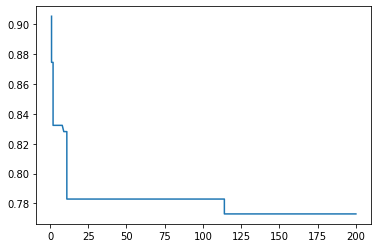

In [111]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.show()

In [85]:
df_training.to_csv(f"./data/{simulation_setup}_vanilla_BO.csv", index = None)